# **Import Libraries**

In [1]:
import os
import time
import random
import collections
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from sklearn.model_selection import KFold

import cv2
from PIL import Image
import shutil

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.transforms import functional as F
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


import warnings
warnings.filterwarnings("ignore")

# **Fix Randomness**

In [2]:
def fix_all_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    os.environ['PYTHONHASHSEED'] = str(seed)


fix_all_seeds(2023)

## Preparing the dataset

In [3]:
# fetch kaggle api from drive
!pip install gdown
import gdown
from google.colab import output

url = 'https://drive.google.com/u/0/uc?id=1wM4mgEoy4ndNunvSZAjAUxF0l0dhi6mw&export=download'

gdown.download(url=url)
output.clear()

In [4]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [5]:
!kaggle competitions download -c sartorius-cell-instance-segmentation

100% 2.31G/2.31G [01:17<00:00, 34.5MB/s]
100% 2.31G/2.31G [01:17<00:00, 32.0MB/s]


In [6]:
!mkdir dataset
!unzip /content/sartorius-cell-instance-segmentation.zip -d dataset
!rm /content/sartorius-cell-instance-segmentation.zip

output.clear()

# **Configurations**

In [7]:
# DATA_DIR must be changed
DATA_DIR = '/content/dataset/'

TRAIN_CSV = DATA_DIR + 'train.csv'
TRAIN_PATH = DATA_DIR + 'train/'
TEST_PATH = DATA_DIR + 'test/'

NORMALIZE = False                         # Normalize to resnet mean and std if True. Be set in transforms().
RESNET_MEAN = (0.485, 0.456, 0.406)
RESNET_STD = (0.229, 0.224, 0.225)
IMG_SIZE = (224, 224)                     # size of resized image for model input
HEIGHT = 520                              # height of the provided train image
WIDTH = 704                               # width of the provided train image

H_LAYER = 256
BOX_DETECTIONS_PER_IMG = 790
MIN_SCORE = 0.59
MASK_THRESHOLD = 0.5   # Changes the confidence required for a pixel to be kept for a mask. Only used 0.5 till now.


BATCH_SIZE = 2
BATCH_SHUFFLE = True
EPOCHS = 18

USE_SCHEDULER = False  # Use a StepLR scheduler if True. Not tried yet.
MOMENTUM = 0.95
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0005

# CELL_TYPES  = {0: 'shsy5y', 1: 'astro', 2: 'cort'}
CLASSES_NUM = 4        # 3 types of cell + 1 type as background
FOLDS = 3              # Kfold cross-validation


## Set device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using {DEVICE} device')

Using cpu device


In [8]:
# These are slight redefinitions of torch.transformation classes
# The difference is that they handle the target and the mask
# Copied from Abishek, added new ones

class Compose():
    def __init__(self, transforms):
        self.transforms = transforms


    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)

        return image, target




class VerticalFlip():
    def __init__(self, prob):
        self.prob = prob


    def __call__(self, image, target):
        if random.random() < self.prob:                  # 实现 VerticalFlip 的概率小于初始化的 prob
            height, weight = image.shape[-2:]
            image = image.flip(-2)
            bbox = target["boxes"]
            bbox[:, [1, 3]] = height - bbox[:, [3, 1]]   # 因为 image.flip(-2) 将图片 vertical flip 了，所以相应的 bbox 的范围要做这番调整。
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-2)
        return image, target




class HorizontalFlip():
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:                # 实现 VerticalFlip 的概率小于初始化的 prob
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]  # 因为 image.flip(-1) 将图片 horizontal flip 了，所以相应的 bbox 的范围要做这番调整。
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-1)
        return image, target



class Normalize():
    def __call__(self, image, target):
        image = F.normalize(image, RESNET_MEAN, RESNET_STD)
        return image, target



class ToTensor():
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

In [9]:
class Resize():
    def __call__(self, image, target):
        image = F.resize(image, IMG_SIZE)
        return image, target

## transforms()

In [10]:
def transforms(train=True):
    # transforms = [ToTensor(), Resize()]
    transforms = [ToTensor()]

    if NORMALIZE:        # Set to False in Configurations, cause it can be achieved in params of MRcnn.
        transforms.append(Normalize())

    # Data augmentation for training
    if train:
        transforms.append(HorizontalFlip(0.5))
        transforms.append(VerticalFlip(0.5))

    return Compose(transforms)

## show_gpu_memory()

In [ ]:
def show_gpu_memory(device):
    print(f"Allocated GPU memory: {torch.cuda.memory_allocated(device) / 1024 / 1024:.2f} MB")
    print(f"Cached GPU memory: {torch.cuda.memory_cached(device) / 1024 / 1024:.2f} MB")

show_gpu_memory(DEVICE)

Allocated GPU memory: 0.00 MB
Cached GPU memory: 0.00 MB


In [ ]:
torch.cuda.get_device_properties(DEVICE)

RuntimeError: ignored

## rle_decode()

Decode the RLE (annotation) of an particular cell instance in an image to its correspongding mask.

In [11]:
def rle_decode(rle, img_shape, color=1):
    """Decode the RLE (annotation) of an particular cell instance in an image to its correspongding mask.

    Args:
        rle (str): mask with run length encoding.
        img_shape ((int, int)): (height, width) of the image, also the shape of mask np.ndarray to return.
        color (int): brightness of the mask pixel. Default to 1.

    Returns:
        np.ndarray: 1 - mask, 0 - background.
    """
    rle_list = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (rle_list[0:][::2], rle_list[1:][::2])]
    starts -= 1
    ends = starts + lengths

    mask = np.zeros(img_shape[0] * img_shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        mask[lo:hi] = color

    return mask.reshape(img_shape)

## build_image_mask()

Decode RLEs (annotations) of all cell instance in an image into one mask image.

In [12]:
def build_image_mask(img, rle_list):
    """Decode RLEs (annotations) of all cell instance in an image into one mask image.

    Args:
        img (np.ndarray): image with single channel or multiple channels.
        rle_list (list of str): rles of all cell instances in an image as a list.

    Returns:
        np.ndarray: 1 - mask, 0 - background.
    """
    img_shape = img.shape
    h = img_shape[0]
    w = img_shape[1]

    mask = np.zeros((h, w))
    for rle in rle_list:
        mask += rle_decode(rle, (h, w))
    mask = mask.clip(0,1)

    return mask

# **EDA (Exploratory Data Analysis)**

We will do some **EDA** (Exploratory Data Analysis) of the `train.csv` including **Visualization** of some images so that we can better understand our training dataset.

## Explore `train.csv`

In [13]:
df_train = pd.read_csv(TRAIN_CSV)
df_train.head().append(df_train.tail())

id                                         annotation  width  \
0      0030fd0e6378  118145 6 118849 7 119553 8 120257 8 120961 9 1...    704   
1      0030fd0e6378  189036 1 189739 3 190441 6 191144 7 191848 8 1...    704   
2      0030fd0e6378  173567 3 174270 5 174974 5 175678 6 176382 7 1...    704   
3      0030fd0e6378  196723 4 197427 6 198130 7 198834 8 199538 8 2...    704   
4      0030fd0e6378  167818 3 168522 5 169225 7 169928 8 170632 9 1...    704   
73580  ffdb3cc02eef  3610 3 4311 7 5014 9 5717 11 6420 13 7123 15 7...    704   
73581  ffdb3cc02eef  341585 2 342287 5 342988 10 343690 13 344394 1...    704   
73582  ffdb3cc02eef  47788 3 48490 7 49192 11 49896 13 50599 14 513...    704   
73583  ffdb3cc02eef  333290 1 333993 2 334696 4 335399 5 336102 6 3...    704   
73584  ffdb3cc02eef  249775 2 250477 6 251180 8 251882 11 252585 12...    704   

       height cell_type plate_time sample_date  \
0         520    shsy5y  11h30m00s  2019-06-16   
1         520    shsy5y  11h30m00s  2019-06-16   
2         520    shsy5y  11h30m00s  2019-06-16   
3         520    shsy5y  11h30m00s  2019-06-16   
4         520    shsy5y  11h30m00s  2019-06-16   
73580     520      cort  11h59m00s  2020-11-01   
73581     520      cort  11h59m00s  2020-11-01   
73582     520      cort  11h59m00s  2020-11-01   
73583     520      cort  11h59m00s  2020-11-01   
73584     520      cort  11h59m00s  2020-11-01   

                                sample_id elapsed_timedelta  
0      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
1      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
2      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
3      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
4      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
73580   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00  
73581   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00  
73582   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00  
73583   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00  
73584   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00

In [ ]:
df_train.shape

(73585, 9)

In [ ]:
df_train.dtypes

id                   object
annotation           object
width                 int64
height                int64
cell_type            object
plate_time           object
sample_date          object
sample_id            object
elapsed_timedelta    object
dtype: object

### Cell Type

In [ ]:
df_train.cell_type.value_counts()

shsy5y    52286
cort      10777
astro     10522
Name: cell_type, dtype: int64

### Annotation (RLE)

The segment of training data is provided with **Run length encoding (RLE)** in the `annotation` column.


RLE is a lossless compression technique used to represent data that contains long sequences of repeated values or characters. <a href="https://www.kaggle.com/c/severstal-steel-defect-detection/discussion/102311" style="text-decoration:none">Check out this discussion for a better understanding</a>.


The current dataset has one segment per row.

In [14]:
# train.csv 中 id 列是图片编号，每一行的 annotation 都是该图片中的一个细胞实例的 mask 数据。
# 若一张图片中有 395 个细胞实例的 mask，则这张图片会在表格中出现 395 行。
df_instances = df_train.groupby(['id']).agg({'annotation': 'count', 'cell_type': 'first'})
df_instances.head()

annotation cell_type
id                                
0030fd0e6378         395    shsy5y
0140b3c8f445         108     astro
01ae5a43a2ab          36      cort
026b3c2c4b32          42      cort
029e5b3b89c7          34      cort

In [ ]:
df_instances.shape

(606, 2)

In [15]:
# 每一种细胞类型（一张图片只有一种细胞）它在一张图片中 instance segmentation mask
# (亦即表中对应图片的 annotation 行数) 的总数的分布的分位数情况。
df_instances_pentiles = df_train.groupby(['id']).agg({'annotation': 'count', 'cell_type': 'first'})
df_instances_pentiles = df_instances_pentiles.groupby("cell_type")[['annotation']]\
                                             .describe(percentiles=[0.1, 0.25, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]).astype(int)\
                                             .T.droplevel(level=0).T.drop(['count', '50%', 'std'], axis=1)
df_instances_pentiles

mean  min  10%  25%  75%  80%  85%  90%  95%  99%  max
cell_type                                                        
astro        80    5   28   50  100  105  123  135  150  297  594
cort         33    4   18   23   39   43   46   54   70   93  108
shsy5y      337   49  143  235  429  447  508  539  559  739  790

From above, we can see that the maximum number of instances per image is **790**, which is from the shsy5y type. So we can set the params `box_detections_per_img` in mrcnn model a little bigger than this.

In [ ]:
# Trying with different strategies
df_instances_pentiles['90%'].to_dict()

{'astro': 135, 'cort': 54, 'shsy5y': 539}

### Pixels Per Mask Per `cell_type`

In [ ]:
df_train['n_pixels'] = df_train.annotation.apply(lambda x: np.sum([int(e) for e in x.split()[1:][::2]]))
# 得到每一个 annotation 所描述的 mask 的面积（像素点个数）。

# 各类型细胞的一个 annotation 对应的一个 instance segmentation mask 的像素点个数的分布的分位数情况。
df_pixels = df_train.groupby("cell_type")[['n_pixels']].describe(percentiles=[0.02, 0.05, 0.1, 0.9, 0.95, 0.98])\
                    .astype(int).T.droplevel(level=0).T.drop(['count', '50%', 'std'], axis=1)
df_pixels

mean  min   2%   5%  10%   90%   95%   98%    max
cell_type                                                   
astro       905   37  136  185  251  1799  2380  3447  13327
cort        240   33   74   95  114   404   497   624   2054
shsy5y      224   30   59   77   96   393   478   593   2254

### Image Shape and Format

In [ ]:
df_train.width.unique()

array([704])

In [ ]:
df_train.height.unique()

array([520])

In [ ]:
img_shapes = set()
img_exts = set()
img_paths = Path(TRAIN_PATH).glob("*")

bar = tqdm(img_paths, total=df_train.id.unique().shape[0])    # should not be: total=len(list(img_paths))

for img_path in bar:
    img_bgr = cv2.imread(img_path.as_posix())                 # BGR mode
    img_rgb = img_bgr[:, :, ::-1]                             # RGB mode

    img_shapes.add(img_rgb.shape)
    img_exts.add(img_path.suffix)
print(f'Image shapes are {img_shapes}.')
print(f'Image extensions are {img_exts}.')

  0%|          | 0/606 [00:00<?, ?it/s]

Image shapes are {(520, 704, 3)}.
Image extensions are {'.png'}.


## Plot Histogram of Pixel Values

Generating a pixel value histogram can aid in identifying outlier images, such as those containing entirely zero-valued pixels.

As the figure displayed below, the image signals appear to be quite uniform, which is characteristic of typical microscopy images. :)

  0%|          | 0/606 [00:00<?, ?it/s]

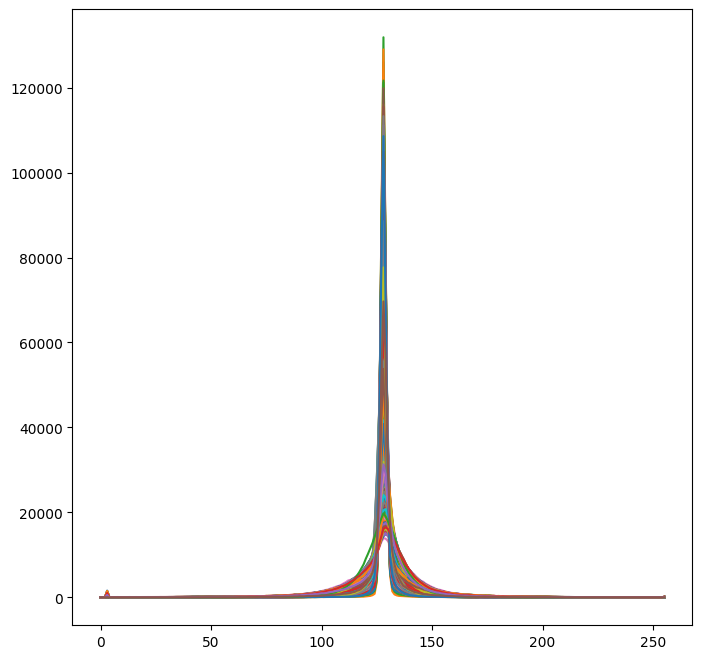

In [ ]:
img_paths = Path(TRAIN_PATH).glob("*")
bar = tqdm(img_paths, total=df_train.id.unique().shape[0])     # should not be: total=len(list(img_paths))

plt.figure(figsize=(8,8))
for img_path in bar:
    img_bgr = cv2.imread(img_path.as_posix())    # BGR mode
    img_rgb = img_bgr[:, :, ::-1]                # RGB mode

    hist = cv2.calcHist([img_rgb], [0], None ,[256], [0,256])
    plt.plot(hist)
plt.show()

## Display Some Images and Masks

### shsy5y

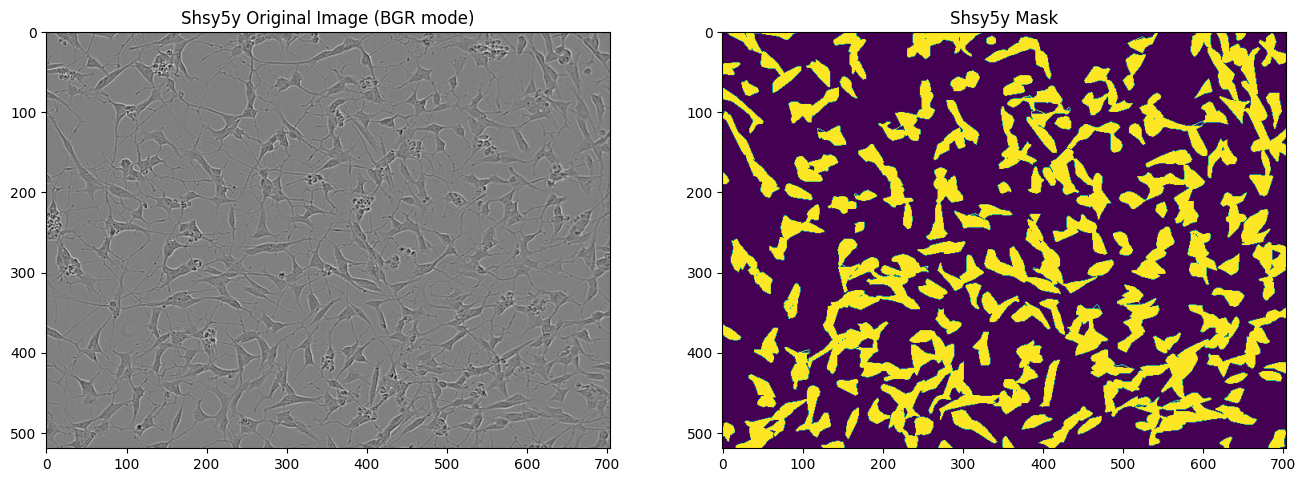

In [ ]:
plt.figure(figsize=(16, 8))
img_id = "0030fd0e6378"
img = cv2.imread(TRAIN_PATH + img_id + ".png")         # BGR mode
ax1 = plt.subplot(121)
ax1.imshow(img)
ax1.set_title("Shsy5y Original Image (BGR mode)")

mask = build_image_mask(img, df_train[df_train.id == img_id].annotation.tolist())
ax2 = plt.subplot(122)
ax2.imshow(mask)
ax2.set_title("Shsy5y Mask")

plt.show()

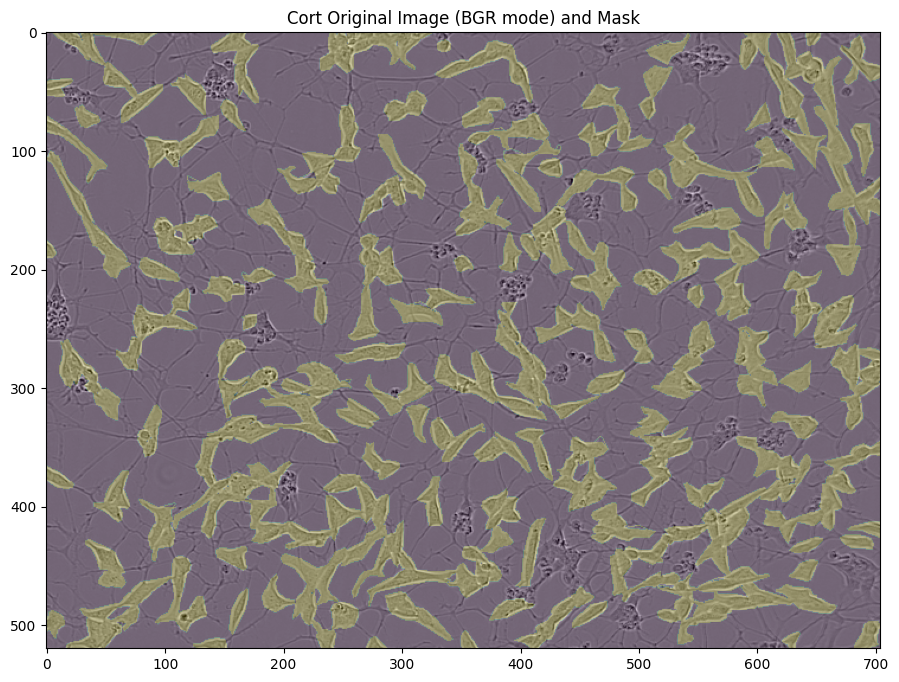

In [ ]:
plt.figure(figsize=(16, 8))
img_id = "0030fd0e6378"
img = cv2.imread(TRAIN_PATH + img_id + ".png")          # BGR mode
plt.imshow(img)
plt.title("Cort Original Image (BGR mode) and Mask")

mask = build_image_mask(img, df_train[df_train.id == img_id].annotation.tolist())
plt.imshow(mask, alpha=0.2)

plt.show()

### astro

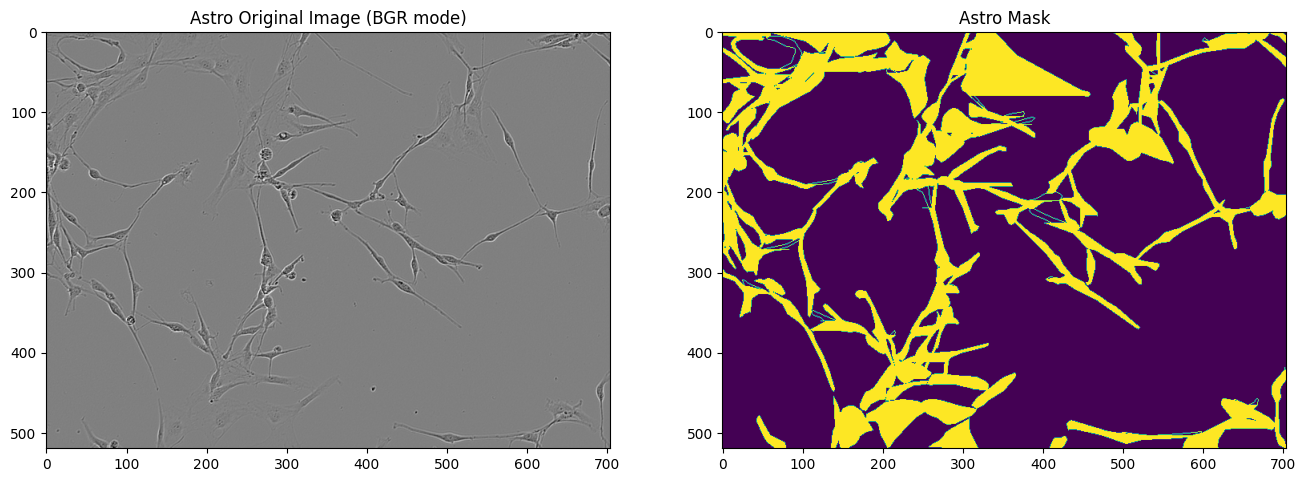

In [ ]:
plt.figure(figsize=(16, 8))
img_id = "0140b3c8f445"
img = cv2.imread(TRAIN_PATH + img_id + ".png")         # BGR mode
ax1 = plt.subplot(121)
ax1.imshow(img)
ax1.set_title("Astro Original Image (BGR mode)")

mask = build_image_mask(img, df_train[df_train.id == img_id].annotation.tolist())
ax2 = plt.subplot(122)
ax2.imshow(mask)
ax2.set_title("Astro Mask")

plt.show()

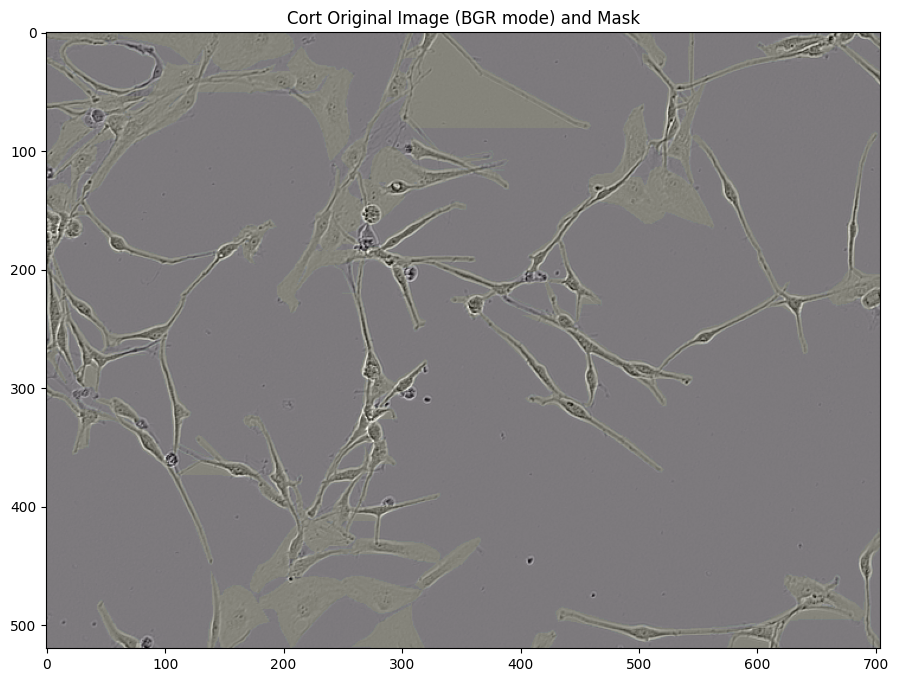

In [ ]:
plt.figure(figsize=(16, 8))
img_id = "0140b3c8f445"
img = cv2.imread(TRAIN_PATH + img_id + ".png")          # BGR mode
plt.imshow(img)
plt.title("Cort Original Image (BGR mode) and Mask")

mask = build_image_mask(img, df_train[df_train.id == img_id].annotation.tolist())
plt.imshow(mask, alpha=0.05)

plt.show()

### cort

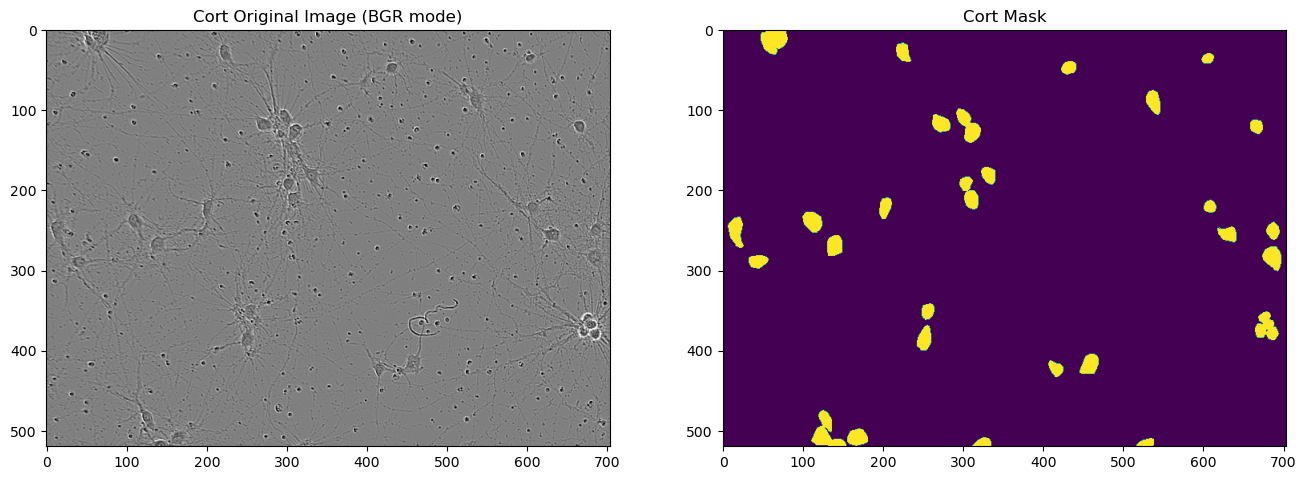

In [ ]:
plt.figure(figsize=(16, 8))
img_id = "01ae5a43a2ab"
img = cv2.imread(TRAIN_PATH + img_id + ".png")         # BGR mode
ax1 = plt.subplot(121)
ax1.imshow(img)
ax1.set_title("Cort Original Image (BGR mode)")

mask = build_image_mask(img, df_train[df_train.id == img_id].annotation.tolist())
ax2 = plt.subplot(122)
ax2.imshow(mask)
ax2.set_title("Cort Mask")

plt.show()

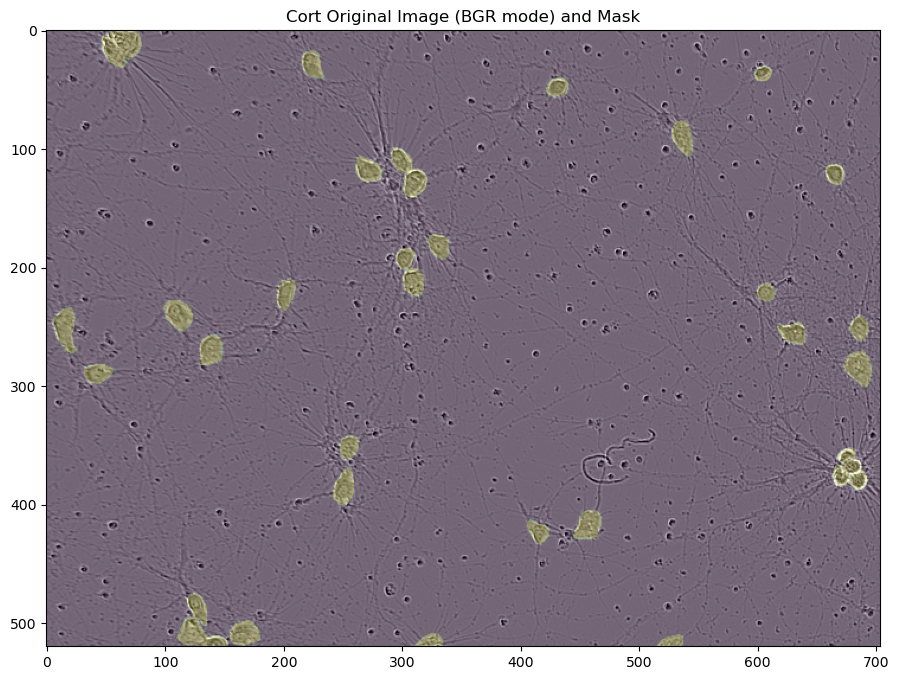

In [ ]:
plt.figure(figsize=(16, 8))
img_id = "01ae5a43a2ab"
img = cv2.imread(TRAIN_PATH + img_id + ".png")          # BGR mode
plt.imshow(img)
plt.title("Cort Original Image (BGR mode) and Mask")

mask = build_image_mask(img, df_train[df_train.id == img_id].annotation.tolist())
plt.imshow(mask, alpha=0.2)

plt.show()

<br>

# Dataset and DataLoader

## Define CellDataset()

In [16]:
class CellDataset(Dataset):
    def __init__(self, df, train_path, transforms=None):
        super().__init__()
        self.df = df                    # df_train
        self.train_path = train_path
        self.transforms = transforms
        self.img_info = collections.defaultdict(dict)

        ## Encoding cell_type by dict
        ## result: {'shsy5y': 1, 'astro': 2, 'cort': 3}
        cell_type_dict = dict.fromkeys(df_train.cell_type.unique())  # {'shsy5y': None, 'astro': None, 'cort': None}
        v = 0
        for k in cell_type_dict.keys():
            v += 1
            cell_type_dict[k] = v

        ## All annotations of the same id are summarized into a list, and the corresponding cell type information is reserved.
        df_info = df.groupby("id").agg({"annotation": lambda x: list(x),
                                        "cell_type": "first"}) \
                                  .reset_index()
        for idx, row in df_info.iterrows():
            self.img_info[idx] = {'image_id': row['id'],
                                  'image_path': os.path.join(self.train_path, row['id'] + '.png'),
                                  'annotations': row["annotation"],
                                  'cell_type' : cell_type_dict[row['cell_type']]}



    def get_box(self, instance_mask):
        """Get the bounding box of a given mask of an instance in an image"""
        pos = np.where(instance_mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])

        return [xmin, ymin, xmax, ymax]



    def __getitem__(self, idx):
        """Get the image and target"""
        info = self.img_info[idx]
        img_path = info["image_path"]
        img = Image.open(img_path).convert("RGB")    # L mode -> RGB mode, also: 1 channel -> 3 channels
        n_instances = len(info["annotations"])

        masks = np.zeros((n_instances, HEIGHT, WIDTH), dtype=np.uint8)
        boxes = []
        for i, annotation in enumerate(info["annotations"]):
            msk = rle_decode(annotation, (HEIGHT, WIDTH))
            # msk = Image.fromarray(msk)
            # if self.should_resize:
            #     msk = msk.resize((self.width, self.height), resample=Image.BILINEAR)
            # msk = np.array(msk) > 0
            masks[i, :, :] = msk
            boxes.append(self.get_box(msk))

        # dummy labels
        labels = [info["cell_type"] for _ in range(n_instances)]

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])    # area of each box
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.int8)
        image_id = torch.tensor([idx])
        iscrowd = torch.zeros((n_instances,), dtype=torch.int64)

        # The required target for the Mask R-CNN
        target = {"boxes": boxes,
                  'labels': labels,
                  'masks': masks,
                  'image_id': image_id,
                  'area': area,
                  'iscrowd': iscrowd}

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target



    def __len__(self):
        return len(self.img_info)

## Define DataLoader

In [17]:
dataset_train = CellDataset(df=df_train, train_path=TRAIN_PATH, transforms=transforms(train=True))

dataloder_train = DataLoader(dataset_train,
                             batch_size=BATCH_SIZE,
                             shuffle=BATCH_SHUFFLE,
                             # num_workers=2,
                             collate_fn=lambda x: tuple(zip(*x))
                             )

# **Setting modified_mask_rcnn:**

In [18]:
!git clone https://github.com/robintzeng/mask-rcnn-Pytorch.git
!cd mask-rcnn-Pytorch

Cloning into 'mask-rcnn-Pytorch'...
remote: Enumerating objects: 593, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 593 (delta 126), reused 117 (delta 70), pack-reused 408
Receiving objects: 100% (593/593), 3.43 MiB | 9.22 MiB/s, done.
Resolving deltas: 100% (298/298), done.


Replace helpers.py with modified_hekpers.py in timm/models/layers directory

In [24]:
os.chdir('/content/mask-rcnn-Pytorch')

In [20]:
%%shell
cat > /content/mask-rcnn-Pytorch/timm/models/layers/modified_helpers.py << EOF
""" Layer/Module Helpers

Hacked together by / Copyright 2020 Ross Wightman
"""
from itertools import repeat
from typing import Iterable, Tuple


def _ntuple(n: int):
    def parse(x: Iterable) -> Tuple:
        if isinstance(x, Iterable):
            return tuple(x)
        return tuple(repeat(x, n))
    return parse


to_1tuple = _ntuple(1)
to_2tuple = _ntuple(2)
to_3tuple = _ntuple(3)
to_4tuple = _ntuple(4)
to_ntuple = _ntuple

/bin/bash: line 21: warning: here-document at line 0 delimited by end-of-file (wanted `EOF')


Replace the content of modified_helpers.py with helpers.py

In [21]:
%%shell
cat /content/mask-rcnn-Pytorch/timm/models/layers/modified_helpers.py > /content/mask-rcnn-Pytorch/timm/models/layers/helpers.py

# Testing with CSPResNet50 as backbone

In [25]:
from model.modified_mask_rcnn import get_model

model = get_model(num_classes=CLASSES_NUM)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/cspresnet50_ra-d3e8d487.pth" to /root/.cache/torch/hub/checkpoints/cspresnet50_ra-d3e8d487.pth


In [26]:
n_batches = len(dataloder_train)

loss_mask_list = np.zeros((EPOCHS, n_batches,))
loss_total_list = np.zeros((EPOCHS, n_batches,))

# freezing the weights
for param in model.parameters():
  param.requires_grad=False

model.to(DEVICE)
model.train()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): TimmToVisionFPN(
    (backbone): FeatureListNet(
      (stem_conv1): ConvBnAct(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (act): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
      (stem_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (stages_0): CrossStage(
        (conv_exp): ConvBnAct(
          (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNormAct2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (blocks): Sequential(
          (0): ResBottleneck(
            (conv1): ConvBnAct(


# Model and Training

## Define Model

In [ ]:
# os.mkdir('MyModelSave')

In [ ]:
# model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,
#                                                            box_detections_per_img=BOX_DETECTIONS_PER_IMG,
#                                                            image_mean=RESNET_MEAN,
#                                                            image_std=RESNET_STD)    # model with normalization

# # Get the number of input features for FastRCNNPredictor, that is
# # the classification + bounding box regression layers for Faster R-CNN
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# # Replace the pre-trained head with a new one that is consistent with our CLASSES_NUM
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, CLASSES_NUM)


# # Get the number of input features for the mask classifier
# in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
# # Replace the mask predictor with a new one
# model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, H_LAYER, CLASSES_NUM)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:03<00:00, 50.0MB/s]


In [ ]:
# n_batches = len(dataloder_train)

# loss_mask_list = np.zeros((EPOCHS, n_batches,))
# loss_total_list = np.zeros((EPOCHS, n_batches,))

# model.to(DEVICE)
# model.train();     # 句尾添加分号 ; 会抑制输出

In [ ]:
# %%time

# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# for epoch in range(1, EPOCHS + 1):
#     print("="*40 + f" Starting epoch {epoch} of {EPOCHS} " + "="*40)

#     time_start = time.time()
#     loss_total_accum = 0.0
#     loss_mask_accum = 0.0

#     for batch_idx, (images, targets) in enumerate(dataloder_train, 1):

#         # Predict
#         images = list(image.to(DEVICE) for image in images)
#         targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

#         loss_dict = model(images, targets)
#         loss_total = sum(loss for loss in loss_dict.values())

#         # Backprop
#         optimizer.zero_grad()
#         loss_total.backward()
#         optimizer.step()

#         # Logging
#         loss_total_accum += loss_total.item()
#         loss_mask = loss_dict['loss_mask'].item()
#         loss_mask_accum += loss_mask

#         loss_mask_list[epoch - 1, batch_idx - 1] = loss_mask
#         loss_total_list[epoch - 1, batch_idx - 1] = loss_total.item()

#         if (batch_idx % 50 == 0) or (batch_idx == n_batches):
#             print(f"[Batch {batch_idx:3d} / {n_batches:3d}] Batch total loss: {loss_total.item():7.3f}. Batch mask loss: {loss_mask:7.3f}")

#     if USE_SCHEDULER:
#         lr_scheduler.step()

#     # Average training loss at this epoch
#     loss_total_avg = loss_total_accum / n_batches
#     loss_mask_avg = loss_mask_accum / n_batches

#     # Time consuming of this training epoch
#     elapsed = time.time() - time_start


#     torch.save(model.state_dict(), f"./MyModelSave/pytorch_mrcnn-epoch{epoch}.bin")

#     print()
#     prefix = f"[Epoch {epoch:2d} / {EPOCHS:2d}]"
#     print(f"{prefix} Epoch average mask loss : {loss_mask_avg:7.3f}")
#     print(f"{prefix} Epoch average total loss: {loss_total_avg:7.3f}.")
#     print(f"{prefix} time elapsed: [{elapsed:.0f} secs]")


#     fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
#     ax1.set_ylim(0, 1)
#     ax1.plot(loss_mask_list[epoch-1])
#     ax1.set_ylabel("Mask Loss")

#     ax2.set_ylim(0, 3)
#     ax2.plot(loss_total_list[epoch-1])
#     ax2.set_ylabel("Total Loss")
#     ax2.set_xlabel("Batches")
#     plt.show()

======================================== Starting epoch 1 of 18 ========================================


KeyboardInterrupt: ignored

# Prediction

## Test Dataset and DataLoader

In [28]:
class CellTestDataset(Dataset):
    def __init__(self, test_path, transforms=None):
        self.transforms = transforms
        self.image_dir = test_path
        self.image_ids = [file_name[:-4] for file_name in os.listdir(self.image_dir)]


    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id + ".png")
        image = Image.open(image_path).convert("RGB")    # Realize the conversion of single-channel grayscale images to three-channel

        if self.transforms is not None:
            image, _ = self.transforms(image=image, target=None)

        return {'image': image, 'image_id': image_id}


    def __len__(self):
        return len(self.image_ids)

In [29]:
dataset_test = CellTestDataset(TEST_PATH, transforms=transforms(train=False))
# len(dataset_test)   # 3
dataset_test[0]

{'image': tensor([[[0.5333, 0.5216, 0.4078,  ..., 0.4980, 0.4902, 0.5020],
          [0.6549, 0.6431, 0.5804,  ..., 0.5020, 0.5020, 0.5059],
          [0.5098, 0.5333, 0.5255,  ..., 0.5059, 0.5020, 0.5098],
          ...,
          [0.4980, 0.4941, 0.5020,  ..., 0.5059, 0.4980, 0.5020],
          [0.5020, 0.4980, 0.5059,  ..., 0.5059, 0.4980, 0.5059],
          [0.5020, 0.4980, 0.4980,  ..., 0.4980, 0.5059, 0.4980]],
 
         [[0.5333, 0.5216, 0.4078,  ..., 0.4980, 0.4902, 0.5020],
          [0.6549, 0.6431, 0.5804,  ..., 0.5020, 0.5020, 0.5059],
          [0.5098, 0.5333, 0.5255,  ..., 0.5059, 0.5020, 0.5098],
          ...,
          [0.4980, 0.4941, 0.5020,  ..., 0.5059, 0.4980, 0.5020],
          [0.5020, 0.4980, 0.5059,  ..., 0.5059, 0.4980, 0.5059],
          [0.5020, 0.4980, 0.4980,  ..., 0.4980, 0.5059, 0.4980]],
 
         [[0.5333, 0.5216, 0.4078,  ..., 0.4980, 0.4902, 0.5020],
          [0.6549, 0.6431, 0.5804,  ..., 0.5020, 0.5020, 0.5059],
          [0.5098, 0.5333, 0.52

## Predict Testing Dataset

In [30]:
def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b

    return ' '.join(map(str, run_lengths))


def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_and(mask, other_mask)] = 0

    return mask

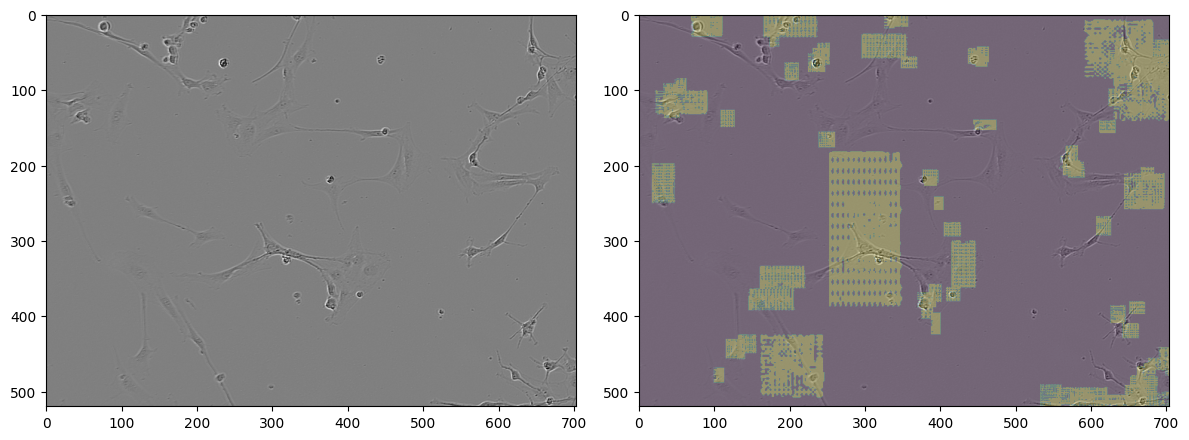

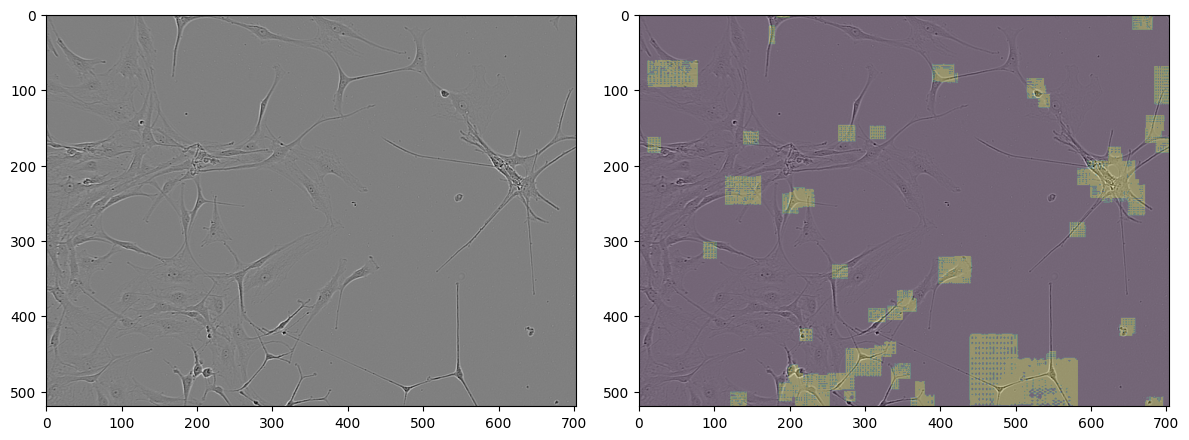

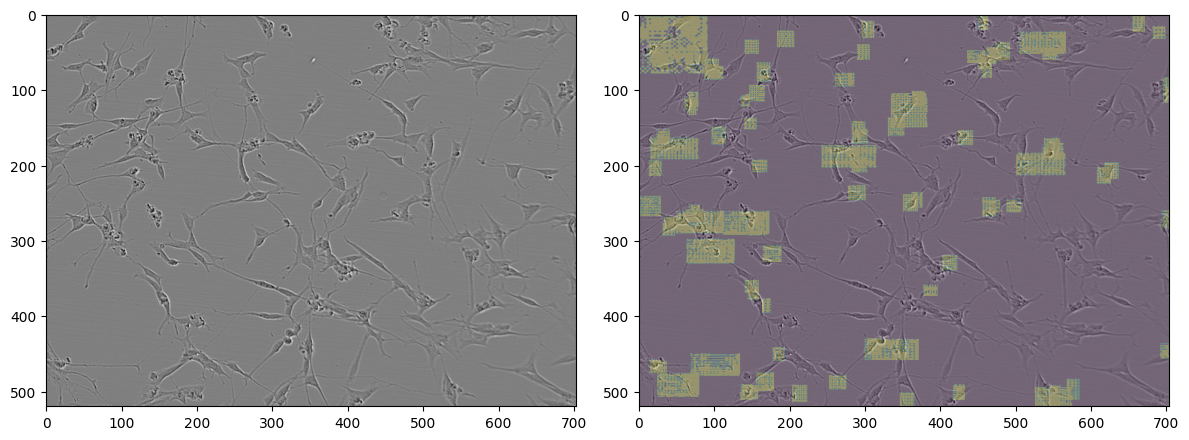

In [31]:
model.eval();

submission = []
for sample in dataset_test:
    img = sample['image']
    image_id = sample['image_id']
    with torch.no_grad():
        result = model([img.to(DEVICE)])[0]

    previous_masks = []
    for i, mask in enumerate(result["masks"]):

        # Filter-out low-scoring results. Not tried yet.
        score = result["scores"][i].cpu().item()
        if score < MIN_SCORE:                   # MIN_SCORE = 0.59
            continue

        mask = mask.cpu().numpy()
        # Keep only highly likely pixels
        binary_mask = mask > MASK_THRESHOLD    # MASK_THRESHOLD = 0.5
        binary_mask = remove_overlapping_pixels(binary_mask, previous_masks)
        previous_masks.append(binary_mask)
        rle = rle_encoding(binary_mask)
        submission.append((image_id, rle))

    plt.figure(figsize=(12,12))
    ax1 = plt.subplot(121)
    ax1.imshow(img.numpy().transpose((1,2,0)))
    all_preds_masks = np.zeros((HEIGHT, WIDTH))
    for mask in result['masks'].cpu().detach().numpy():
        all_preds_masks = np.logical_or(all_preds_masks, mask[0] > MASK_THRESHOLD)
    ax2 = plt.subplot(122)
    ax2.imshow(img.numpy().transpose((1,2,0)))
    ax2.imshow(all_preds_masks, alpha=0.2)
    plt.tight_layout()
    plt.show()


    # Add empty prediction if no RLE was generated for this image
    all_images_ids = [image_id for image_id, rle in submission]
    if image_id not in all_images_ids:
        submission.append((image_id, ""))

In [ ]:
os.chdir('/content/')
os.mkdir('MyModelSave')

In [36]:
df_sub = pd.DataFrame(submission, columns=['id', 'predicted'])
df_sub.to_csv("/content/MyModelSave/My_MRCNN.csv", index=False)
df_sub.head()

id predicted
0  d48ec7815252          
1  d8bfd1dafdc4          
2  7ae19de7bc2a